# ToDo:


1.   Define baseline model, do encoding
2.   Start building models on baseline model, using:
    1.   Naive Bayes
    2.   Logistic Regression
    3.   K-Nearest Neighbors (KNN)         
    4.   SVM ( optional )

3.   Compare the results of first modues. Try to improve logistic regression.

4.   Then go back to preparation part, and compare how it reflects on model quality.

# Set up

In [1]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 4.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=2df48e52f07c47af4bdc3828d985b8702c2039d75738788098d036edb3e65dc1
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting un

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="bright")

import os

from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# library for exporting dataset
from google.colab import files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path1 = '/content/drive/My Drive/Colab Notebooks/EPAM DS foundations course/DS_module3/df_train_prepared.csv'
path2 = '/content/drive/My Drive/Colab Notebooks/EPAM DS foundations course/DS_module3/df_test_prepared.csv'
df_train = pd.read_csv(path1, sep=',')
df_test = pd.read_csv(path2, sep=',')

In [5]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [6]:
df_train.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainToday_encoded,RainTomorrow_encoded,ElevationZone,ClimaticZone,AdminReg,Latitude,Longitude,WindGustDir_East,WindGustDir_North,WindGustDir_South,WindGustDir_West,WindDir3pm_East,WindDir3pm_North,WindDir3pm_South,WindDir3pm_West,WindDir9am_East,WindDir9am_North,WindDir9am_South,WindDir9am_West,Georegion_Central Australia,Georegion_Eastern Australia,Georegion_External Territory,Georegion_Northern Australia,Georegion_Southeastern Australia,Georegion_Southern Australia,Georegion_Tasmania,Georegion_Western Australia,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,2012-11-05,PerthAirport,-0.344486,-0.485284,1.840130,-0.043974,0.608426,0.787922,0.899057,1.413860,-0.202779,-0.459933,-0.862981,-0.290487,0.152753,0.208245,-0.353901,-0.377456,Yes,No,1.0,0.0,Coastal Plain,Mediterranean,Western Australia,-0.132497,-2.156965,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
1,2013-03-02,Walpole,0.609920,0.204245,-0.354477,-0.119083,-0.539088,-0.377218,-0.116347,0.040324,-0.097197,0.705517,-1.128882,-1.125565,0.152753,0.457287,0.741868,0.145637,No,No,0.0,0.0,Coastal,Temperate,Western Australia,0.367818,-2.093061,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
2,2009-08-04,Williamtown,-1.048555,-0.583788,-0.354477,-0.795064,-0.544713,-0.532570,-0.341993,0.040324,0.325132,-0.459933,0.643790,0.365646,1.458015,0.623315,-0.940369,-0.580882,No,No,0.0,0.0,Coastal Plain,Subtropical,New South Wales,0.011136,0.811692,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,2016-05-01,Townsville,1.454803,1.147070,-0.354477,0.932443,0.799679,-0.532570,-0.341993,1.070476,0.219550,0.899759,-0.035734,-0.260662,-0.282334,-0.289840,1.714170,1.104641,No,No,0.0,0.0,Coastal Plain,Tropical,Queensland,-2.224679,0.395872,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
4,2015-02-03,NorahHead,1.079299,0.373109,3.657538,-0.119083,0.839054,1.487007,1.801639,1.413860,-0.255570,0.656957,0.259711,0.305998,0.152753,-0.206826,0.772735,0.392653,Yes,No,1.0,0.0,Coastal,Subtropical,New South Wales,0.088106,0.788923,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


In [7]:
df_test.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainToday_encoded,RainTomorrow_encoded,ElevationZone,ClimaticZone,AdminReg,Latitude,Longitude,WindGustDir_East,WindGustDir_North,WindGustDir_South,WindGustDir_West,WindDir3pm_East,WindDir3pm_North,WindDir3pm_South,WindDir3pm_West,WindDir9am_East,WindDir9am_North,WindDir9am_South,WindDir9am_West,Georegion_Central Australia,Georegion_Eastern Australia,Georegion_External Territory,Georegion_Northern Australia,Georegion_Southeastern Australia,Georegion_Southern Australia,Georegion_Tasmania,Georegion_Western Australia,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,2014-03-31,Ballarat,0.328292,0.753053,-0.354477,NaN,NaN,-0.066514,1.124703,-0.188599,0.008385,-0.896976,0.274483,0.291085,NaN,NaN,0.170833,0.857625,No,No,0.0,0.0,Hilly,Temperate,Victoria,0.794065,0.150430,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
1,2016-06-17,PerthAirport,-0.266256,-0.865229,-0.354477,-1.621264,0.495925,-0.221866,-0.116347,0.154785,0.166759,0.511276,0.806285,0.962130,-1.587596,-1.036966,-0.647135,-1.002262,No,No,0.0,0.0,Coastal Plain,Mediterranean,Western Australia,-0.132497,-2.156965,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
2,2016-06-02,Hobart,-1.736979,-1.596973,-0.320186,-1.621264,0.383423,-0.765598,0.560589,-0.875367,1.064206,0.025672,2.047155,2.184923,-0.717421,-0.621896,-2.267639,-1.481764,No,No,0.0,0.0,Coastal Plain,Temperate,Tasmania,1.671447,0.438092,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
3,2016-04-23,NorahHead,0.609920,-0.246060,1.565804,NaN,NaN,2.496795,1.801639,3.588625,0.958624,0.559836,0.747196,1.081427,NaN,NaN,0.325167,-0.203092,Yes,No,1.0,0.0,Coastal,Subtropical,New South Wales,0.088106,0.788923,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,2013-11-12,Nhil,-0.876449,-0.302348,-0.217314,NaN,NaN,0.477218,0.560589,1.871705,0.694669,-0.022889,0.111989,0.037580,NaN,NaN,-0.755169,-0.508230,No,No,0.0,0.0,Plain,Semi-arid,Victoria,0.591307,-0.031587,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28202 entries, 0 to 28201
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   MinTemp                           28137 non-null  float64
 1   MaxTemp                           28169 non-null  float64
 2   Rainfall                          27982 non-null  float64
 3   Evaporation                       16242 non-null  float64
 4   Sunshine                          14840 non-null  float64
 5   WindGustSpeed                     26577 non-null  float64
 6   WindSpeed9am                      28082 non-null  float64
 7   WindSpeed3pm                      27871 non-null  float64
 8   Humidity9am                       27961 non-null  float64
 9   Humidity3pm                       27622 non-null  float64
 10  Pressure9am                       25634 non-null  float64
 11  Pressure3pm                       25646 non-null  float64
 12  Clou

In [12]:
df_test = df_test.fillna(0.0)

# Defining base model

For the baseline model I'd have all features that I had from the start, with a few exceptions:
- I will remove Date, and encode **seasons** and **months**
- I will remove City, ElevationZone, ClimZone, AdminReg, LagLong in favor of **Georegion**
- remove Raintomorrow and Raintoday initial records ( leave only encoded )


## Baseline model scope

In [8]:
df_train = df_train.drop(['Date', 'Location', 'RainTomorrow', 'RainToday', 'Latitude', 'Longitude', 'AdminReg', 'ClimaticZone', 'ElevationZone'], axis=1)
df_test = df_test.drop(['Date', 'Location', 'RainTomorrow', 'RainToday', 'Latitude', 'Longitude', 'AdminReg', 'ClimaticZone', 'ElevationZone'], axis=1)

# splitting datasets into X and y

In [219]:
X_train = df_train.drop('RainTomorrow_encoded', axis=1)
y_train = df_train['RainTomorrow_encoded']

X_test = df_test.drop('RainTomorrow_encoded', axis=1)
y_test = df_test['RainTomorrow_encoded']

# Evaluation functions

In [380]:
def evaluation_report (y_test, y_pred, model_name):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) # sklearn.metrics
    print(f"{model_name}'s Accuracy is : {accuracy}\n\n")

    # Confusion matrix
    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", confusion_table(y_test, y_pred))

    # Calculate metrics: FN, NP, FN, FP
    my_conf_matrix = confusion_matrix(y_test, y_pred)
    true_neg = my_conf_matrix[0, 0]
    true_pos = my_conf_matrix[1, 1]
    false_neg = my_conf_matrix[1, 0]
    false_pos = my_conf_matrix[0, 1]

    print(f"\nTrue Negatives: {true_neg}")
    print(f"True Positives: {true_pos}")
    print(f"False Negatives: {false_neg}")
    print(f"False Positives: {false_pos}")

    # Overall
    overall = true_neg + true_pos + false_neg + false_pos
    print(f"Overall: {overall}")

    # Classification report
    print("\nClassification report:")
    classification_rep = classification_report(y_test, y_pred)
    print(classification_rep)

    # Precision, recall
    print("\nRates:")
    accuracy = (true_neg + true_pos) / overall
    precision = true_pos / (true_pos + false_pos)
    false_positive_rate = false_pos / (false_pos + true_neg)
    recall = true_pos / (true_pos + false_neg)
    f1 = 2 * (precision * recall) / (precision + recall)

    #print
    print(f"Precision (TPR): {precision}")
    print(f"False Positive Rate (FPR): {false_positive_rate}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

In [364]:
def show_roc_curve(y_test, y_pred_proba, model_name):
    # ROC curve
    fprs, tprs, thresholds = roc_curve(y_test, y_pred_proba)
    #roc_auc = auc(fprs, tprs)
    plt.plot(fprs, tprs)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"\n{model_name} ROC Curve")
    plt.show()

    # Roc Auc Score
    print(f"\nRoc Auc Score: {roc_auc_score(y_test, y_pred_proba)}")

# Modeling

## Naive Bayes

In [321]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday_encoded,WindGustDir_East,WindGustDir_North,WindGustDir_South,WindGustDir_West,WindDir3pm_East,WindDir3pm_North,WindDir3pm_South,WindDir3pm_West,WindDir9am_East,WindDir9am_North,WindDir9am_South,WindDir9am_West,Georegion_Central Australia,Georegion_Eastern Australia,Georegion_External Territory,Georegion_Northern Australia,Georegion_Southeastern Australia,Georegion_Southern Australia,Georegion_Tasmania,Georegion_Western Australia,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,-0.344486,-0.485284,1.840130,-0.043974,0.608426,0.787922,0.899057,1.413860,-0.202779,-0.459933,-0.862981,-0.290487,0.152753,0.208245,-0.353901,-0.377456,1.0,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
1,0.609920,0.204245,-0.354477,-0.119083,-0.539088,-0.377218,-0.116347,0.040324,-0.097197,0.705517,-1.128882,-1.125565,0.152753,0.457287,0.741868,0.145637,0.0,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
2,-1.048555,-0.583788,-0.354477,-0.795064,-0.544713,-0.532570,-0.341993,0.040324,0.325132,-0.459933,0.643790,0.365646,1.458015,0.623315,-0.940369,-0.580882,0.0,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,1.454803,1.147070,-0.354477,0.932443,0.799679,-0.532570,-0.341993,1.070476,0.219550,0.899759,-0.035734,-0.260662,-0.282334,-0.289840,1.714170,1.104641,0.0,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
4,1.079299,0.373109,3.657538,-0.119083,0.839054,1.487007,1.801639,1.413860,-0.255570,0.656957,0.259711,0.305998,0.152753,-0.206826,0.772735,0.392653,1.0,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


In [300]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112804 entries, 0 to 112803
Data columns (total 53 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   MinTemp                           112804 non-null  float64
 1   MaxTemp                           112804 non-null  float64
 2   Rainfall                          112804 non-null  float64
 3   Evaporation                       112804 non-null  float64
 4   Sunshine                          112804 non-null  float64
 5   WindGustSpeed                     112804 non-null  float64
 6   WindSpeed9am                      112804 non-null  float64
 7   WindSpeed3pm                      112804 non-null  float64
 8   Humidity9am                       112804 non-null  float64
 9   Humidity3pm                       112804 non-null  float64
 10  Pressure9am                       112804 non-null  float64
 11  Pressure3pm                       112804 non-null  f

In [301]:
X_train['RainToday_encoded'].fillna(0.0, inplace=True)

<ipython-input-301-ab37ed6fec73>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['RainToday_encoded'].fillna(0.0, inplace=True)


In [365]:
# Initialize and train the Gaussian Naive Bayes classifier
NB = GaussianNB()
NB.fit(X_train, y_train)

GaussianNB()

In [366]:
# Make predictions on the test set
y_pred = NB.predict(X_test)

### Evaluate the model

In [383]:
evaluation_report(y_test, y_pred, 'Gaussian Naive Bayes')

Gaussian Naive Bayes's Accuracy is : 0.778916388908588


Confusion matrix:
 Truth        0.0   1.0
Predicted             
0.0        17850  4014
1.0         2221  4117

True Negatives: 17850
True Positives: 4117
False Negatives: 2221
False Positives: 4014
Overall: 28202

Classification report:
              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85     21864
         1.0       0.51      0.65      0.57      6338

    accuracy                           0.78     28202
   macro avg       0.70      0.73      0.71     28202
weighted avg       0.80      0.78      0.79     28202


Rates:
Precision (TPR): 0.5063337842823761
False Positive Rate (FPR): 0.18358946212952798
Recall: 0.6495739981066583
F1 Score: 0.5690787200221162


In [368]:
# Calculate predicted probabilities for the positive class
y_pred_proba = NB.predict_proba(X_test)[:, 1]
len(y_pred_proba)

28202

In [369]:
y_pred_proba

array([1.05816821e-02, 6.49975790e-05, 8.33970836e-02, ...,
       1.74625051e-04, 7.83535867e-09, 9.83999989e-01])

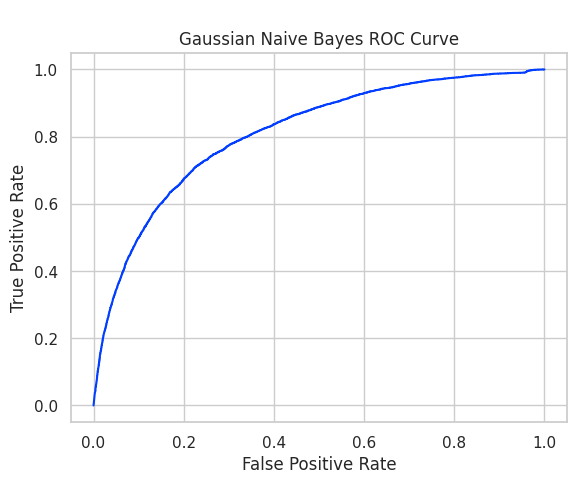


Roc Auc Score: 0.8108781665528793


In [370]:
show_roc_curve(y_test, y_pred_proba, 'Gaussian Naive Bayes')

### Ajusting the threshold

In [371]:
# Set threshold
threshold = 0.3

# Create new predictions based on threshold
y_pred_30 = (y_pred_proba >= threshold).astype(int)

In [382]:
evaluation_report(y_test, y_pred_30, 'Gaussian Naive Bayes(adjusted)')

Gaussian Naive Bayes(adjusted)'s Accuracy is : 0.7613644422381391


Confusion matrix:
 Truth          0     1
Predicted             
0          17016  4848
1           1882  4456

True Negatives: 17016
True Positives: 4456
False Negatives: 1882
False Positives: 4848
Overall: 28202

Classification report:
              precision    recall  f1-score   support

         0.0       0.90      0.78      0.83     21864
         1.0       0.48      0.70      0.57      6338

    accuracy                           0.76     28202
   macro avg       0.69      0.74      0.70     28202
weighted avg       0.81      0.76      0.78     28202


Rates:
Precision (TPR): 0.47893379191745483
False Positive Rate (FPR): 0.2217343578485181
Recall: 0.7030609024929
F1 Score: 0.5697481140519115


## Logistic Regression

In [374]:
# Initialize and train the Logistic Regression classifier
logreg = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [375]:
# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test)

### Evaluate the model

In [381]:
evaluation_report(y_test, y_pred_logreg, 'Logistic Regression')

Logistic Regression's Accuracy is : 0.8453301184313169


Confusion matrix:
 Truth        0.0   1.0
Predicted             
0.0        20924   940
1.0         3422  2916

True Negatives: 20924
True Positives: 2916
False Negatives: 3422
False Positives: 940
Overall: 28202

Classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     21864
         1.0       0.76      0.46      0.57      6338

    accuracy                           0.85     28202
   macro avg       0.81      0.71      0.74     28202
weighted avg       0.84      0.85      0.83     28202


Rates:
Precision (TPR): 0.7562240663900415
False Positive Rate (FPR): 0.042993047932674715
Recall: 0.46008204480908804
F1 Score: 0.5721012360211889


In [384]:
# ROC Curve and AUC
y_pred_proba_logreg = logreg.predict_proba(X_test)[:, 1]
# fprs_logreg, tprs_logreg, thresholds_logreg = roc_curve(y_test, y_pred_proba_logreg)
# roc_auc_logreg = auc(fprs_logreg, tprs_logreg)

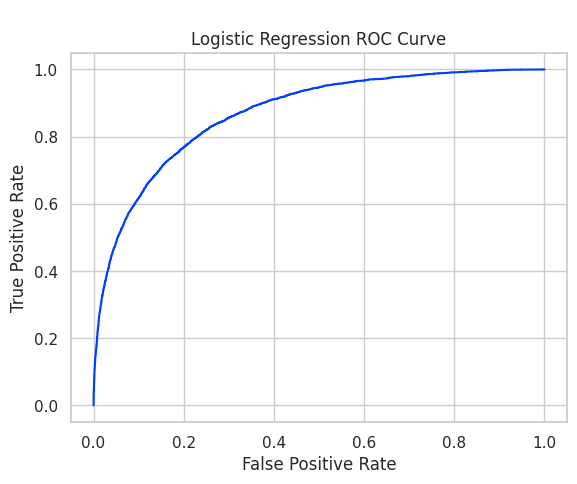


Roc Auc Score: 0.8696212505384848


In [385]:
show_roc_curve(y_test, y_pred_proba_logreg, 'Logistic Regression')

In [120]:
print(f"ROC AUC Score LogReg: {roc_auc_logreg}")

ROC AUC Score LogReg: 0.8696212505384848


### Adjusting the threshold

In [ ]:
TODO!!!!!

In [204]:
desired_tpr = 0.75  # desired true positive rate
idx = (np.abs(tprs_logreg - desired_tpr)).argmin()
my_threshold = thresholds_logreg[idx]
my_threshold

0.2346059186530885

In [205]:
my_threshold = 0.23

In [206]:
y_pred_adjusted = (y_pred_proba >= my_threshold).astype(int)

In [207]:
accuracy_logreg_1 = accuracy_score(y_test, y_pred_adjusted)
print(f"Logistic Regression Accuracy: {accuracy_logreg_1}")

Logistic Regression Accuracy: 0.7511524005389689


In [208]:
confusion_table(y_test, y_pred_adjusted)

Truth,0,1
Predicted,,
0,16604,5260
1,1758,4580


In [209]:
# Classification Report
class_report_logreg = classification_report(y_test, y_pred_adjusted)
print("Classification Report:")
print(class_report_logreg)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.76      0.83     21864
         1.0       0.47      0.72      0.57      6338

    accuracy                           0.75     28202
   macro avg       0.68      0.74      0.70     28202
weighted avg       0.81      0.75      0.77     28202



## KNN

In [237]:
# K-Nearest Neighbors
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [238]:
y_pred_knn = KNN.predict(X_test)

### Evaluating the model

In [239]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Logistic Regression Accuracy: {accuracy_knn}")

Logistic Regression Accuracy: 0.8352953691227573


### Ajusting the number of neighbours

In [240]:
KNN = KNeighborsClassifier(n_neighbors=9)
KNN.fit(X_train, y_train)
y_pred_knn = KNN.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Logistic Regression Accuracy: {accuracy_knn}")

Logistic Regression Accuracy: 0.8404723069285867


In [244]:
KNN = KNeighborsClassifier(n_neighbors=7)
KNN.fit(X_train, y_train)
y_pred_knn = KNN.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Logistic Regression Accuracy: {accuracy_knn}")

Logistic Regression Accuracy: 0.8385930075881143


In [247]:
# Trying different K
for k in range(1, 15):
  knn_ = KNeighborsClassifier(n_neighbors=k)
  knn_pred_ = knn_.fit(X_train, y_train).predict(X_test)
  accuracy_knn = accuracy_score(y_test, knn_pred_)
  print(f'K = {k} and accuracy is {accuracy_knn}' )

K = 1 and accuracy is 0.804517410112758
K = 2 and accuracy is 0.820012765052124
K = 3 and accuracy is 0.8273172115452805
K = 4 and accuracy is 0.8286291752357989
K = 5 and accuracy is 0.8352953691227573
K = 6 and accuracy is 0.834018863910361
K = 7 and accuracy is 0.8385930075881143
K = 8 and accuracy is 0.8365364158570314
K = 9 and accuracy is 0.8404723069285867
K = 10 and accuracy is 0.8385220906318701
K = 11 and accuracy is 0.8422452308346926
K = 12 and accuracy is 0.8386284660662364
K = 13 and accuracy is 0.8424934401815474
K = 14 and accuracy is 0.840578682362953


In [248]:
KNN = KNeighborsClassifier(n_neighbors=11)

In [249]:
KNN.fit(X_train, y_train)
y_pred_knn = KNN.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

In [253]:
confusion_table(y_test, y_pred_knn)

Truth,0.0,1.0
Predicted,,
0.0,21049,815
1.0,3634,2704


In [254]:
# Calculate predicted probabilities for the positive class
y_pred_knn_proba = KNN.predict_proba(X_test)[:, 1]
len(y_pred_proba)

28202

In [255]:
fprs_knn, tprs_knn, thresholds_knn = roc_curve(y_test, y_pred_knn_proba)
roc_auc_knn = auc(fprs_knn, tprs_knn)

Text(0.5, 1.0, 'ROC Curve')

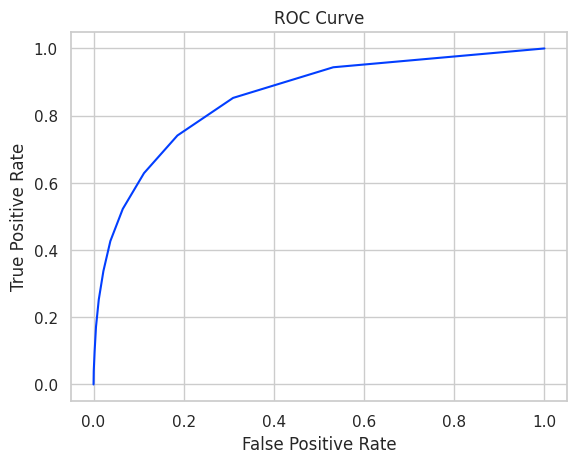

In [256]:
plt.plot(fprs_knn, tprs_knn)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

## SVM

ToDo:
- try different threshold ( https://www.youtube.com/watch?v=4jRBRDbJemM&t=627s )
- select important features
- feature engineering

- split test/train BEFORE imputation and scaling

# Conclusion

*   1
*   2